# Dynamic Analysis
In this experiment I will try to see the maximal values of lift obtained at the highest flapping frequencies possible (without damaging) 606.8g (5.95N).  Voltage on power source is set to 11.6V with motor = linear_interp(motor_raw, 0, 250, 1342, 290)

In [2]:
import matplotlib.pyplot as plt
from utils import *
import numpy as np
import plotly.express as px
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [3]:
!python -m serial.tools.list_ports
daq_port = '/dev/ttyUSB0'
command_port = "/dev/ttyACM0"

/dev/ttyUSB0        
1 ports found


measurements = read_measurements_df_6axis(port=daq_port, duration=5)

measurements['Time'] = 0 
calib = measurements.mean() 
calib.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231204/data/calib.csv')

In [26]:
calib = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231204/data/calib.csv', index_col=0).iloc[:,0]

In [10]:
def fitness_avg_force(measurements, plot=False, args = {'peak_height':0, 'peak_distance':10}):
    """
    Interpolates sensor data between the first and last detected peaks and calculates the mean
    of the interpolated 'Fy' and 'Fz' columns to compute a score as the Euclidean norm.

    :param measurements: (pandas.DataFrame) A DataFrame containing sensor data with at least 'Time',
                                       'Fy', and 'Fz' columns.

    :return: score: (float) The Euclidean norm of the mean values of 'Fy' and 'Fz' from the
                     interpolated data.
    """
    df = measurements.copy()
    interpolated_df, peaks = peak_slice_interpolate(df, args)

    # interpolated_df now contains 1000 interpolated data points based on the 'Time' column.

    Fy, Fz = interpolated_df.mean()[['Fy', 'Fz']]
    score = np.sqrt(Fy ** 2 + Fz ** 2)

    if plot:
        # Create the base line plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        # Plot 'Fz' column
        ax1.plot(df['Time'], df['Fz'], label='Fz')
        ax1.plot(df['Time'], df['Fy'], label='Fy', zorder=1)
        # Plot the peaks
        ax1.scatter(df['Time'][peaks], df['Fy'][peaks], color='red', s=10, label='Peaks', zorder=5)
        # Adding title and labels
        ax1.legend()
        ax1.set_title('Peaks found')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Force')
        # Setting up a simple plot with equal scaling on the axes
        # Setting the aspect of the plot to be equal.
        ax2.set_aspect('equal', adjustable='box')

        # Drawing a simple line for demonstration
        ax2.plot(interpolated_df.Fy, interpolated_df.Fz, zorder=1)
        ax2.scatter(Fy, Fz, c='r', marker='*')
        ax2.scatter(0, 0, c='g', marker='+')
        ax2.arrow(0, 0, Fy, Fz, head_width=0.3, head_length=0.3)

        # Setting labels for the axes
        ax2.set_xlabel('Fy')
        ax2.set_ylabel('Fz')
        ax2.set_title(f'Score: {round(score, 2)}')

        # Display the plot
        plt.show()

    return score

## Experiment 1
I will use folding and medium leg movement and use the controller to increase the frequency to its maximum to see how high the force turns out to be.

measurements = read_measurements_df_6axis(port=daq_port, duration=30) - calib
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/_.csv', index=False)

In [50]:
px.line(measurements, x='Time', y=['Fz', 'Fy'])

In [68]:
sliced_df = measurements[measurements['Time'].between(20,24.7)].reset_index(drop=True) -calib
fitness_avg_force(sliced_df, plot=True, args={'peak_height':0, 'peak_distance':10})

## Experiment 2
With a bit more power

In [75]:
measurements = read_measurements_df_6axis(port=daq_port, duration=30)
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231204/data/experiment2.csv', index=False)

In [6]:
px.line(measurements, x='Time', y=['Fz', 'Fy'])

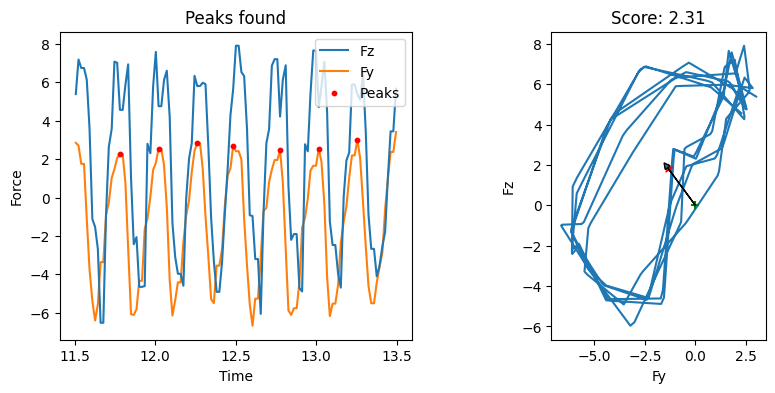

2.3131172662934545

In [78]:
sliced_df = measurements[measurements['Time'].between(11.5,13.5)].reset_index(drop=True) - calib
fitness_avg_force(sliced_df, plot=True, args={'peak_height':0, 'peak_distance':10})

In [79]:
2.31/5.95

0.38823529411764707

Fazit: Not really

## Experiment 3
I raised the power to 11.6V with motor = linear_interp(motor_raw, 0, 250, 1342, 360). I will gradually increase power using the controller and extended legs and folding


measurements = read_measurements_df_6axis(port=daq_port, duration=30) - calib

measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231204/data/experiment3.csv', index=False)

In [4]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231204/data/experiment3.csv')

In [18]:
px.line(measurements, x='Time', y=['Fz', 'Fy'])

I will now do a sliding window were I analyze the frequency against the total force.

In [14]:
df_sliced = measurements[measurements['Time'].between(20, 23)].reset_index(drop=True)

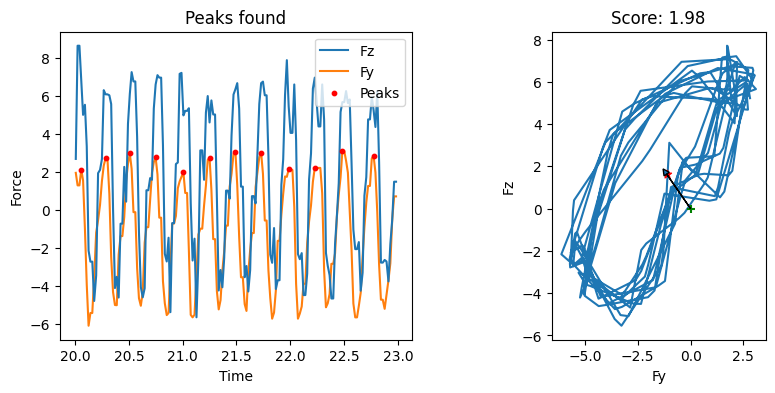

1.984758972777968

In [16]:
fitness_avg_force(df_sliced, plot=True, args = {'peak_height':0, 'peak_distance':10})

In [9]:
frequencies = []
lift = []
force = []

for i in np.arange(3,21,1):
    start =  i
    end = start +2
    window = df_sliced[df_sliced['Time'].between(start, end)].copy()
    interpolated_df, peaks = peak_slice_interpolate(window)
    lift.append(interpolated_df['Fz'].mean())
    force.append(np.sqrt(interpolated_df['Fz'].mean()**2 + interpolated_df['Fy'].mean()**2))
    frequencies.append(1/window.iloc[peaks]['Time'].diff().mean())
    
df = pd.DataFrame({'Frequency':frequencies, 'Lift':lift, 'Force':force})

In [11]:
px.scatter(df,x='Frequency', y=['Lift', 'Force'])

Fazit:
-The highest frequency does not reach the desired 5.95N, this shows that higher frequency is needed, on my opinion only achievable with a new gear structure that ensures safety of the Batbot.

## Experiment 4
I raised the power to 11.6V with motor = linear_interp(motor_raw, 0, 250, 1342, 360). I will gradually increase power using the controller and extended legs and extended wings. The idea is to see how much is the increase on the resulting force, as I believe that folding and unfolding might be useful for straight flight but not for hovering. I have the idea that maybe we should first aim for maximal resulting force, independent on the direction and the use the legs to keep the Batbot in that orientation, this means that most likely the position of the Batbot will be very vertical, for which not folding could be beneficial as the upstroke can also generate lift in this configuration.

In [19]:
measurements = read_measurements_df_6axis(port=daq_port, duration=30) - calib

In [31]:
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231204/data/experiment4.csv', index=False)

In [32]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231204/data/experiment4.csv')

In [33]:
px.line(measurements, x='Time', y=['Fz', 'Fy'])

In [40]:
df_sliced = measurements[measurements['Time'].between(5, 17)].reset_index(drop=True)

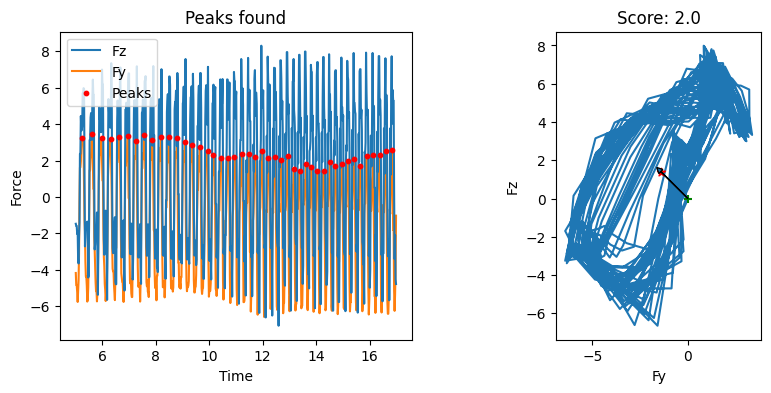

2.0000011649835656

In [41]:
fitness_avg_force(df_sliced, plot=True, args = {'peak_height':0, 'peak_distance':10})

In [35]:
frequencies = []
lift = []
force = []

for i in np.arange(5,15,1):
    start =  i
    end = start + 2
    window = df_sliced[df_sliced['Time'].between(start, end)].copy()
    interpolated_df, peaks = peak_slice_interpolate(window)
    lift.append(interpolated_df['Fz'].mean())
    force.append(np.sqrt(interpolated_df['Fz'].mean()**2 + interpolated_df['Fy'].mean()**2))
    frequencies.append(1/window.iloc[peaks]['Time'].diff().mean())
    
df = pd.DataFrame({'Frequency':frequencies, 'Lift':lift, 'Force':force})

In [36]:
px.scatter(df,x='Frequency', y=['Lift', 'Force'])

Fazit:
We do see a slight better resulting force but clearly the lift is not as good as the experiment 3.